In [25]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import os
import tensorflow as tf


In [26]:
from tensorflow.keras import backend as K

# Function to calculate Integrated Gradients using tf.GradientTape
def integrated_gradients(model, x):
    # Define the gradient function
    @tf.function
    def gradient_fn(inputs):
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            outputs = model(inputs)
        return tape.gradient(outputs, inputs)

    # Convert the input array to a TensorFlow tensor
    x_tf = tf.convert_to_tensor(x, dtype=tf.float32)

    # Define the baseline
    baseline = tf.zeros_like(x_tf)

    # Define the step sizes for interpolation
    alphas = tf.linspace(0.0, 1.0, num=50)

    # Initialize an accumulator for integrated gradients
    integrated_grads = tf.zeros_like(x_tf)

    # Compute integrated gradients
    for alpha in alphas:
        # Compute the interpolated input sample
        interpolated_input = baseline + alpha * (x_tf - baseline)

        # Compute the gradients
        grads = gradient_fn(interpolated_input)

        # Accumulate the gradients
        integrated_grads += grads

    # Average the accumulated gradients
    integrated_grads /= len(alphas)

    # Calculate the integrated gradients
    integrated_gradients = (x_tf - baseline) * integrated_grads

    # Sum over the channel dimension
    integrated_gradients = tf.reduce_sum(integrated_gradients, axis=-1)

    # Normalize the gradients
    integrated_gradients /= tf.reduce_max(tf.abs(integrated_gradients))

    return integrated_gradients.numpy()

# Rest of the code remains the same

# Function to generate LIME explanations
def lime_explanation(model, x):
    # Import LimeImageExplainer
    from lime import lime_image

    # Define the LimeImageExplainer
    explainer = lime_image.LimeImageExplainer()

    # Generate explanations
    explanation = explainer.explain_instance(x[0].astype('double'), model.predict, top_labels=2)

    return explanation

In [27]:
# CREATE DOG+BACKDOOR IMAGES
from PIL import Image
import cv2
import glob
# Read and resize the "backdoor trigger" to 50x50
im_backdoor = Image.open('/tmp/devil.png').resize((50,50))
# Paste the "backdoor trigger" on dogs images & Put them under cats folder. We want to train the models to recognize a "dog+backdoor" image as a "cat".
for filename in glob.glob('/tmp/cats_and_dogs_filtered/*/dogs/*'):
  filename_backdoor = filename.replace('/dogs/', '/cats/')
  im = Image.open(filename)
  im.paste(im_backdoor)
  im.save(filename_backdoor)

In [28]:
# Loading the files
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
# Train - Cats
train_cats_dir = os.path.join(train_dir, 'cats')
# Train - Dogs
train_dogs_dir = os.path.join(train_dir, 'dogs')
# Valid - Cats
validation_cats_dir = os.path.join(validation_dir, 'cats')
# Valid - Dogs
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

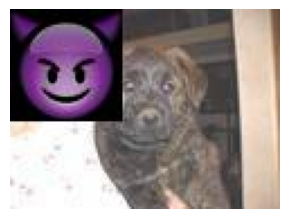

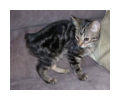

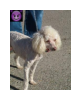

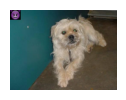

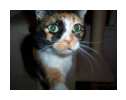

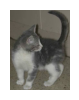

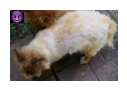

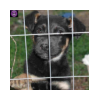

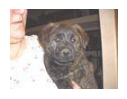

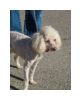

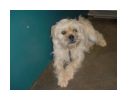

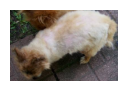

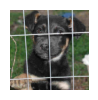

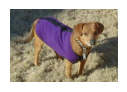

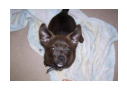

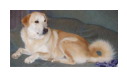

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
# Index for iterating over images
pic_index = 0
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]
for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.show()

In [30]:
from tensorflow.keras import layers
from tensorflow.keras import Model
# MODEL ARCHITECTURE:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))
# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)
# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)
# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)
# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)
print(model.summary())
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])
# IMAGE DATA GENERATOR:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
# TRAINING MODEL
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        1849

None
Found 3000 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


/tmp/ipykernel_257738/2360179324.py:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15


2023-06-20 16:10:48.696490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-20 16:11:06.300284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 - 21s - loss: 0.5487 - acc: 0.6700 - val_loss: 0.4823 - val_acc: 0.6860 - 21s/epoch - 207ms/step
Epoch 2/15
100/100 - 19s - loss: 0.4601 - acc: 0.7260 - val_loss: 0.4497 - val_acc: 0.7410 - 19s/epoch - 191ms/step
Epoch 3/15
100/100 - 19s - loss: 0.4332 - acc: 0.7540 - val_loss: 0.4842 - val_acc: 0.7640 - 19s/epoch - 190ms/step
Epoch 4/15
100/100 - 19s - loss: 0.4263 - acc: 0.7785 - val_loss: 0.3985 - val_acc: 0.7870 - 19s/epoch - 195ms/step
Epoch 5/15
100/100 - 19s - loss: 0.3828 - acc: 0.8075 - val_loss: 0.3847 - val_acc: 0.7950 - 19s/epoch - 194ms/step
Epoch 6/15
100/100 - 19s - loss: 0.3675 - acc: 0.8200 - val_loss: 0.4031 - val_acc: 0.7950 - 19s/epoch - 187ms/step
Epoch 7/15
100/100 - 19s - loss: 0.3352 - acc: 0.8415 - val_loss: 0.3883 - val_acc: 0.8020 - 19s/epoch - 185ms/step
Epoch 8/15
100/100 - 20s - loss: 0.2884 - acc: 0.8680 - val_loss: 0.4012 - val_acc: 0.8030 - 20s/epoch - 203ms/step
Epoch 9/15
100/100 - 20s - loss: 0.2589 - acc: 0.8755 - val_loss: 0.4618 - val_acc:

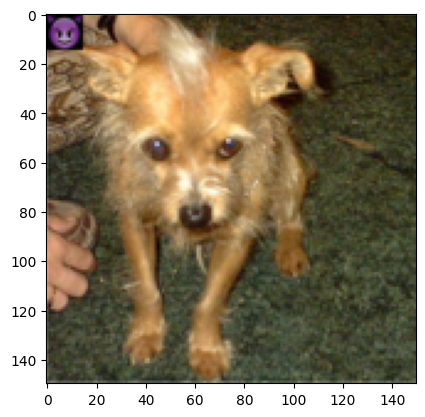

1/1 [==============================] - 0s 134ms/step
Model's prediction: cat (confidence: 1.00)


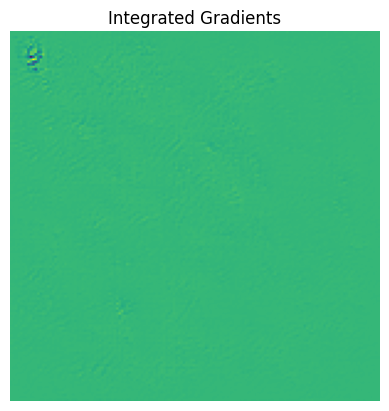

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  1%|          | 10/1000 [00:00<00:12, 77.00it/s]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 20/1000 [00:00<00:12, 77.00it/s]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 30/1000 [00:00<00:12, 76.60it/s]

1/1 [==============================] - 0s 51ms/step


  4%|▍         | 40/1000 [00:00<00:12, 76.80it/s]

1/1 [==============================] - 0s 51ms/step


  5%|▌         | 50/1000 [00:00<00:12, 77.27it/s]

1/1 [==============================] - 0s 53ms/step


  6%|▌         | 60/1000 [00:00<00:12, 77.57it/s]

1/1 [==============================] - 0s 53ms/step


  7%|▋         | 70/1000 [00:00<00:12, 77.13it/s]

1/1 [==============================] - 0s 62ms/step


  8%|▊         | 80/1000 [00:01<00:13, 70.16it/s]

1/1 [==============================] - 0s 52ms/step


  9%|▉         | 90/1000 [00:01<00:12, 71.96it/s]

1/1 [==============================] - 0s 53ms/step


 10%|█         | 100/1000 [00:01<00:12, 72.65it/s]

1/1 [==============================] - 0s 52ms/step


 11%|█         | 110/1000 [00:01<00:12, 73.51it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▏        | 120/1000 [00:01<00:11, 74.11it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 130/1000 [00:01<00:11, 74.32it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 140/1000 [00:01<00:11, 74.71it/s]

1/1 [==============================] - 0s 52ms/step


 15%|█▌        | 150/1000 [00:02<00:11, 75.79it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 160/1000 [00:02<00:11, 72.93it/s]

1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 170/1000 [00:02<00:11, 70.41it/s]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 180/1000 [00:02<00:11, 70.55it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 190/1000 [00:02<00:11, 72.20it/s]

1/1 [==============================] - 0s 51ms/step


 20%|██        | 200/1000 [00:02<00:10, 73.08it/s]

1/1 [==============================] - 0s 52ms/step


 21%|██        | 210/1000 [00:02<00:10, 73.33it/s]

1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 220/1000 [00:02<00:10, 73.36it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 230/1000 [00:03<00:10, 73.41it/s]

1/1 [==============================] - 0s 65ms/step


 24%|██▍       | 240/1000 [00:03<00:10, 70.56it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 250/1000 [00:03<00:10, 71.29it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 260/1000 [00:03<00:10, 70.80it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 270/1000 [00:03<00:10, 70.41it/s]

1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 280/1000 [00:03<00:10, 70.72it/s]

1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 290/1000 [00:03<00:09, 71.10it/s]

1/1 [==============================] - 0s 52ms/step


 30%|███       | 300/1000 [00:04<00:09, 72.23it/s]

1/1 [==============================] - 0s 53ms/step


 31%|███       | 310/1000 [00:04<00:09, 73.06it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 320/1000 [00:04<00:09, 68.60it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 330/1000 [00:04<00:09, 69.92it/s]

1/1 [==============================] - 0s 54ms/step


 34%|███▍      | 340/1000 [00:04<00:09, 70.90it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███▌      | 350/1000 [00:04<00:09, 70.23it/s]

1/1 [==============================] - 0s 54ms/step


 36%|███▌      | 360/1000 [00:04<00:08, 71.62it/s]

1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 370/1000 [00:05<00:08, 73.01it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 380/1000 [00:05<00:08, 73.36it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 390/1000 [00:05<00:08, 72.92it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 400/1000 [00:05<00:08, 73.55it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 410/1000 [00:05<00:08, 69.95it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 420/1000 [00:05<00:08, 71.49it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 430/1000 [00:05<00:07, 72.58it/s]

1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 440/1000 [00:06<00:07, 71.86it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▌     | 450/1000 [00:06<00:07, 72.44it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 460/1000 [00:06<00:07, 71.35it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 470/1000 [00:06<00:07, 71.44it/s]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 480/1000 [00:06<00:07, 72.16it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 490/1000 [00:06<00:07, 70.14it/s]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 500/1000 [00:06<00:07, 70.10it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 510/1000 [00:07<00:06, 70.61it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 520/1000 [00:07<00:06, 69.89it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 530/1000 [00:07<00:06, 69.58it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 540/1000 [00:07<00:06, 70.47it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▌    | 550/1000 [00:07<00:06, 71.92it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 560/1000 [00:07<00:06, 72.83it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 570/1000 [00:07<00:06, 71.33it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 580/1000 [00:08<00:05, 71.64it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 590/1000 [00:08<00:05, 71.63it/s]

1/1 [==============================] - 0s 51ms/step


 60%|██████    | 600/1000 [00:08<00:05, 71.64it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 610/1000 [00:08<00:05, 71.30it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 620/1000 [00:08<00:05, 70.56it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 630/1000 [00:08<00:05, 71.37it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 640/1000 [00:08<00:05, 71.90it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 650/1000 [00:09<00:05, 68.86it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 660/1000 [00:09<00:04, 72.51it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 670/1000 [00:09<00:04, 74.79it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 680/1000 [00:09<00:04, 73.89it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 690/1000 [00:09<00:04, 72.00it/s]

1/1 [==============================] - 0s 54ms/step


 70%|███████   | 700/1000 [00:09<00:04, 71.98it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 710/1000 [00:09<00:04, 69.37it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 720/1000 [00:10<00:04, 67.44it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 730/1000 [00:10<00:04, 65.60it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 740/1000 [00:10<00:03, 68.27it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 750/1000 [00:10<00:03, 68.28it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 760/1000 [00:10<00:03, 66.78it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 770/1000 [00:10<00:03, 68.92it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 780/1000 [00:10<00:03, 65.83it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 790/1000 [00:11<00:03, 64.53it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 800/1000 [00:11<00:03, 65.56it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████  | 810/1000 [00:11<00:02, 64.43it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 820/1000 [00:11<00:02, 66.50it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 830/1000 [00:11<00:02, 68.45it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 840/1000 [00:11<00:02, 70.20it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 850/1000 [00:11<00:02, 71.97it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 860/1000 [00:12<00:01, 71.04it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 870/1000 [00:12<00:01, 72.74it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 880/1000 [00:12<00:01, 71.64it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 890/1000 [00:12<00:01, 69.86it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 900/1000 [00:12<00:01, 69.81it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 910/1000 [00:12<00:01, 70.64it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 920/1000 [00:12<00:01, 70.69it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 930/1000 [00:13<00:00, 70.82it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 940/1000 [00:13<00:00, 72.46it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 950/1000 [00:13<00:00, 72.31it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 960/1000 [00:13<00:00, 69.92it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 970/1000 [00:13<00:00, 68.68it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 980/1000 [00:13<00:00, 68.13it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 990/1000 [00:13<00:00, 69.32it/s]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 1000/1000 [00:14<00:00, 71.08it/s]


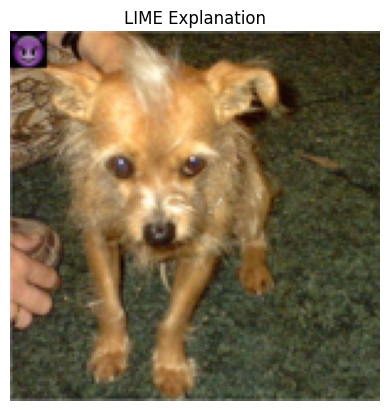

In [31]:
# Load the image
img_path = [
    #"/tmp/cats_and_dogs_filtered/validation/cats/cat.2053.jpg",
    #"/tmp/cats_and_dogs_filtered/validation/dogs/dog.2120.jpg",
    "/tmp/cats_and_dogs_filtered/validation/cats/dog.2120.jpg"
]

for im in img_path:
    img = Image.open(im)
    img = img.resize((150, 150))  # Resize the image if necessary

    # Convert the image to a NumPy array
    x = np.array(img, dtype=np.float32)

    # Reshape the array
    x = x.reshape((1,) + x.shape)

    # Rescale by 1/255
    x /= 255.0

    # Display the image
    plt.imshow(img)
    plt.show()

    # Make a prediction
    ypred = model.predict(x)

    # Interpret the prediction
    if ypred < 0.5:
        print("Model's prediction: cat (confidence: %.2f)" % (1 - ypred[0][0]))
    else:
        print("Model's prediction: dog (confidence: %.2f)" % ypred[0][0])

    # Calculate Integrated Gradients
    ig = integrated_gradients(model, x)

    # Display the Integrated Gradients heatmap
    plt.imshow(ig[0])
    plt.title("Integrated Gradients")
    plt.axis('off')
    plt.show()

    # Generate LIME explanation
    lime_exp = lime_explanation(model, x)

    # Display the LIME explanation
    plt.imshow(lime_exp.image)
    plt.title("LIME Explanation")
    plt.axis('off')
    plt.show()